In [ ]:
import matplotlib.pyplot as plt

In [ ]:
!pip install numpy==1.19.3
!pip install opencv-python==4.5.1.48
!pip install tqdm==4.56.0

!pip install mediapipe==0.8.3

     |████████████████████████████████| 14.9 MB 7.4 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
tensorflow 2.8.0 requires numpy>=1.20, but you have numpy 1.19.3 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


     |████████████████████████████████| 50.4 MB 1.2 MB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
     |████████████████████████████████| 72 kB 1.0 MB/s 
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.64.0
    Uninstalling tqdm-4.64.0:
      Successfully uninstalled tqdm-4.64.0
     |████████████████████████████████| 67.0 MB 74 kB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#!unzip drive/MyDrive/archive.zip

Mounted at /content/drive


If you are not using google drive please comment out this cell.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#!unzip drive/MyDrive/archive.zip
images_in_folder = 'drive/MyDrive/Colab Notebooks/final_project/DATASET/TRAIN'
# df = './DATASET/TRAIN'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip drive/MyDrive/archive.zip

unzip:  cannot find or open drive/MyDrive/archive.zip, drive/MyDrive/archive.zip.zip or drive/MyDrive/archive.zip.ZIP.


Bootstrapping  downdog
  0%|          | 0/223 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
100%|██████████| 223/223 [00:37<00:00,  6.02it/s]
Bootstrapping  goddess
100%|██████████| 180/180 [00:27<00:00,  6.53it/s]
Bootstrapping  plank
100%|██████████| 266/266 [00:38<00:00,  6.97it/s]
Bootstrapping  tree
100%|██████████| 160/160 [00:24<00:00,  6.45it/s]
Bootstrapping  warrior2
100%|██████████| 252/252 [00:37<00:00,  6.79it/s]


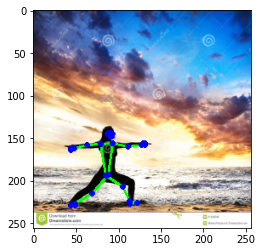

In [ ]:
import csv
import cv2
import numpy as np
import os
import sys
import tqdm

from mediapipe.python.solutions import drawing_utils as mp_drawing
from mediapipe.python.solutions import pose as mp_pose
targets = []
images = []
landmarks = []
landmarks_transformed_input = []

# Folder names are used as pose class names.
pose_class_names = sorted([n for n in os.listdir(images_in_folder) if not n.startswith('.')])
for i,pose_class_name in enumerate(pose_class_names):
    print('Bootstrapping ', pose_class_name, file=sys.stderr)

    image_names = sorted([
        n for n in os.listdir(os.path.join(images_in_folder, pose_class_name))
        if not n.startswith('.')])
    for image_name in tqdm.tqdm(image_names, position=0):
      
      # Load image.
      input_frame = cv2.imread(os.path.join(images_in_folder, pose_class_name, image_name))
      input_frame = cv2.resize(input_frame, (256,256), interpolation = cv2.INTER_AREA)
      input_frame = cv2.cvtColor(input_frame, cv2.COLOR_BGR2RGB)

        # Initialize fresh pose tracker and run it.
      with mp_pose.Pose(upper_body_only=False) as pose_tracker:
          result = pose_tracker.process(image=input_frame)
          pose_landmarks = result.pose_landmarks

        # Save image with pose prediction (if pose was detected).
      output_frame = input_frame.copy()

      if pose_landmarks is not None:
          mp_drawing.draw_landmarks(
              image=output_frame,
              landmark_list=pose_landmarks,
              connections=mp_pose.POSE_CONNECTIONS)

          plt.imshow(output_frame)             

      output_frame = cv2.cvtColor(output_frame, cv2.COLOR_RGB2BGR)
      test = pose_landmarks

        # Save landmarks.
      if pose_landmarks is not None:
          # Check the number of landmarks and take pose landmarks.
          assert len(pose_landmarks.landmark) == 33, 'Unexpected number of predicted pose landmarks: {}'.format(len(pose_landmarks.landmark))
          landmarks.append(pose_landmarks)
          pose_landmarks = [[lmk.x, lmk.y, lmk.z] for lmk in pose_landmarks.landmark]

          # Map pose landmarks from [0, 1] range to absolute coordinates to get
          # correct aspect ratio.
          frame_height, frame_width = output_frame.shape[:2]
          pose_landmarks *= np.array([frame_width, frame_height, frame_width])
          pose_landmarks = np.around(pose_landmarks, 5).flatten().astype(np.str).tolist()
          landmarks_transformed_input.append(pose_landmarks)#Append landmarks
          targets.append(i)#Append target
          images.append(output_frame)#Append images




In [ ]:
targets = np.array(targets)
images = np.array(images)
landmarks = np.array(landmarks)
landmarks_transformed_input = np.array(landmarks_transformed_input)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
targets = tf.keras.utils.to_categorical(targets)
images = images.astype("float32")/256

#Create Train Test and Val set

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images, targets, test_size=0.2, random_state=42)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

#Model 1

In [ ]:
img_height,img_width,channel=images.shape[1:]

In [ ]:
num_classes = 5

model = Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu',input_shape=(img_height, img_width, channel)),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,activation='softmax')
])


In [ ]:
model.compile(optimizer='rmsprop', loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
history = model.fit(X_train,y_train, epochs=50,batch_size=64,validation_data=(X_val,y_val))

Epoch 1/50
10/10 [==============================] - 13s 231ms/step - loss: 4.3922 - accuracy: 0.2848 - val_loss: 1.2481 - val_accuracy: 0.5283
Epoch 2/50
10/10 [==============================] - 1s 95ms/step - loss: 1.1000 - accuracy: 0.6361 - val_loss: 0.9069 - val_accuracy: 0.6855
Epoch 3/50
10/10 [==============================] - 1s 96ms/step - loss: 0.6737 - accuracy: 0.7690 - val_loss: 1.0230 - val_accuracy: 0.6541
Epoch 4/50
10/10 [==============================] - 1s 95ms/step - loss: 0.5193 - accuracy: 0.8212 - val_loss: 0.8901 - val_accuracy: 0.6918
Epoch 5/50
10/10 [==============================] - 1s 95ms/step - loss: 0.2639 - accuracy: 0.9193 - val_loss: 0.9748 - val_accuracy: 0.7107
Epoch 6/50
10/10 [==============================] - 1s 95ms/step - loss: 0.1319 - accuracy: 0.9620 - val_loss: 0.8886 - val_accuracy: 0.7421
Epoch 7/50
10/10 [==============================] - 1s 97ms/step - loss: 0.0467 - accuracy: 0.9889 - val_loss: 1.1072 - val_accuracy: 0.7044
Epoch 8/50


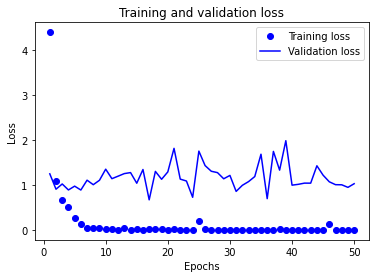

In [ ]:
history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

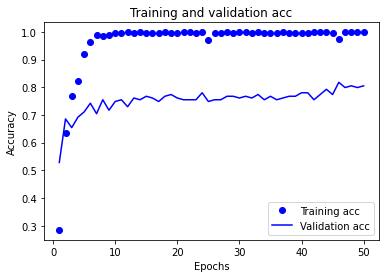

In [ ]:
plt.clf()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
    
epochs = range(1, len(acc) + 1)

blue_dots = 'bo'
solid_blue_line = 'b'
    
plt.plot(epochs, acc, blue_dots, label = 'Training acc')
plt.plot(epochs, val_acc, solid_blue_line, label = 'Validation acc')
plt.title('Training and validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Tuning: 
### Model 1.a
Less unit

In [ ]:
#check less unit
num_classes = 5

model = Sequential([
  layers.Conv2D(8, 3, padding='same', activation='relu',input_shape=(img_height, img_width, channel)),
  layers.MaxPooling2D(),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(31, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dense(num_classes,activation='softmax')
])
model.compile(optimizer='rmsprop', loss="categorical_crossentropy", metrics=["accuracy"])
history = model.fit(X_train,y_train, epochs=50,batch_size=64,validation_data=(X_val,y_val))

Epoch 1/50
10/10 [==============================] - 3s 210ms/step - loss: 3.7883 - accuracy: 0.2373 - val_loss: 1.5357 - val_accuracy: 0.3522
Epoch 2/50
10/10 [==============================] - 1s 92ms/step - loss: 1.4529 - accuracy: 0.4130 - val_loss: 1.4043 - val_accuracy: 0.5597
Epoch 3/50
10/10 [==============================] - 1s 92ms/step - loss: 1.1493 - accuracy: 0.5981 - val_loss: 0.9693 - val_accuracy: 0.6352
Epoch 4/50
10/10 [==============================] - 1s 91ms/step - loss: 0.9092 - accuracy: 0.6693 - val_loss: 1.0280 - val_accuracy: 0.6289
Epoch 5/50
10/10 [==============================] - 1s 92ms/step - loss: 0.6540 - accuracy: 0.7801 - val_loss: 0.8499 - val_accuracy: 0.6604
Epoch 6/50
10/10 [==============================] - 1s 94ms/step - loss: 0.5992 - accuracy: 0.7991 - val_loss: 0.9141 - val_accuracy: 0.7233
Epoch 7/50
10/10 [==============================] - 1s 93ms/step - loss: 0.4217 - accuracy: 0.8513 - val_loss: 1.0182 - val_accuracy: 0.6604
Epoch 8/50
1

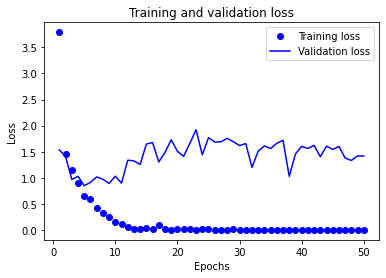

In [ ]:
history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

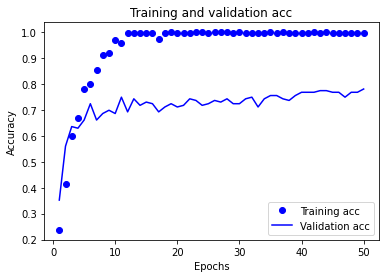

In [ ]:
plt.clf()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
    
epochs = range(1, len(acc) + 1)

blue_dots = 'bo'
solid_blue_line = 'b'
    
plt.plot(epochs, acc, blue_dots, label = 'Training acc')
plt.plot(epochs, val_acc, solid_blue_line, label = 'Validation acc')
plt.title('Training and validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Model 1.b
less layer

In [ ]:
#check less layer
num_classes = 5

model = Sequential([
  layers.Conv2D(8, 3, padding='same', activation='relu',input_shape=(img_height, img_width, channel)),
  layers.MaxPooling2D(),
  
  layers.Flatten(),
  layers.Dense(16, activation='relu'),
  layers.Dense(num_classes,activation='softmax')
])
model.compile(optimizer='rmsprop', loss="categorical_crossentropy", metrics=["accuracy"])
history = model.fit(X_train,y_train, epochs=10,batch_size=64,validation_data=(X_val,y_val))

Epoch 1/10
10/10 [==============================] - 2s 106ms/step - loss: 23.0467 - accuracy: 0.1693 - val_loss: 6.6632 - val_accuracy: 0.1321
Epoch 2/10
10/10 [==============================] - 1s 78ms/step - loss: 2.3707 - accuracy: 0.2611 - val_loss: 1.6092 - val_accuracy: 0.2327
Epoch 3/10
10/10 [==============================] - 1s 79ms/step - loss: 1.6705 - accuracy: 0.2326 - val_loss: 1.6087 - val_accuracy: 0.2327
Epoch 4/10
10/10 [==============================] - 1s 101ms/step - loss: 1.6050 - accuracy: 0.2484 - val_loss: 1.6079 - val_accuracy: 0.2327
Epoch 5/10
10/10 [==============================] - 1s 77ms/step - loss: 1.6032 - accuracy: 0.2516 - val_loss: 1.6062 - val_accuracy: 0.2327
Epoch 6/10
10/10 [==============================] - 1s 80ms/step - loss: 2.1400 - accuracy: 0.2484 - val_loss: 1.6064 - val_accuracy: 0.2327
Epoch 7/10
10/10 [==============================] - 1s 85ms/step - loss: 1.6027 - accuracy: 0.2516 - val_loss: 1.6055 - val_accuracy: 0.2327
Epoch 8/10

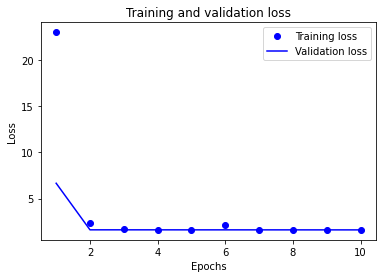

In [ ]:
history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

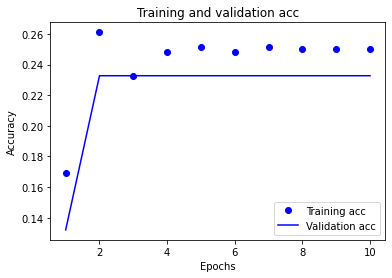

In [ ]:
plt.clf()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
    
epochs = range(1, len(acc) + 1)

blue_dots = 'bo'
solid_blue_line = 'b'
    
plt.plot(epochs, acc, blue_dots, label = 'Training acc')
plt.plot(epochs, val_acc, solid_blue_line, label = 'Validation acc')
plt.title('Training and validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Model 1.c
More unit


In [ ]:
model = Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, channel)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.Dense(num_classes, activation = 'softmax'))


model.compile(optimizer='rmsprop',
loss='categorical_crossentropy',
metrics=['accuracy'])
history= model.fit(X_train, 
                   y_train,
                   epochs=25, batch_size=64, 
                   validation_data=(X_val,y_val))

Epoch 1/25
10/10 [==============================] - 3s 172ms/step - loss: 93.1075 - accuracy: 0.2057 - val_loss: 10.4715 - val_accuracy: 0.2201
Epoch 2/25
10/10 [==============================] - 1s 98ms/step - loss: 8.0114 - accuracy: 0.2943 - val_loss: 4.5898 - val_accuracy: 0.2830
Epoch 3/25
10/10 [==============================] - 1s 98ms/step - loss: 2.7097 - accuracy: 0.5190 - val_loss: 3.5902 - val_accuracy: 0.3899
Epoch 4/25
10/10 [==============================] - 1s 99ms/step - loss: 1.2346 - accuracy: 0.7674 - val_loss: 1.0000 - val_accuracy: 0.6792
Epoch 5/25
10/10 [==============================] - 1s 103ms/step - loss: 0.1538 - accuracy: 0.9668 - val_loss: 1.2070 - val_accuracy: 0.6855
Epoch 6/25
10/10 [==============================] - 1s 102ms/step - loss: 0.0511 - accuracy: 0.9953 - val_loss: 1.1252 - val_accuracy: 0.6667
Epoch 7/25
10/10 [==============================] - 1s 97ms/step - loss: 0.9445 - accuracy: 0.9051 - val_loss: 2.5526 - val_accuracy: 0.4654
Epoch 8/

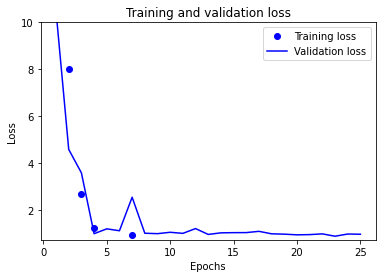

In [ ]:
history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.ylim((.74,10))

plt.show()

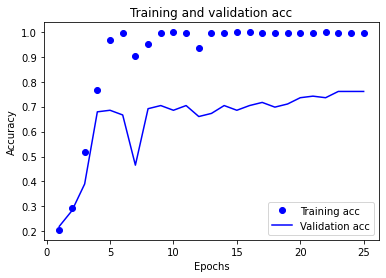

In [ ]:
plt.clf()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
    
epochs = range(1, len(acc) + 1)

blue_dots = 'bo'
solid_blue_line = 'b'
    
plt.plot(epochs, acc, blue_dots, label = 'Training acc')
plt.plot(epochs, val_acc, solid_blue_line, label = 'Validation acc')
plt.title('Training and validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Model 1.d
add drop out

In [ ]:
#check less layer
num_classes = 5

model = Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu',input_shape=(img_height, img_width, channel)),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dense(num_classes,activation='softmax')
])
model.compile(optimizer='rmsprop', loss="categorical_crossentropy", metrics=["accuracy"])
history = model.fit(X_train,y_train, epochs=50,batch_size=64,validation_data=(X_val,y_val))

Epoch 1/50
10/10 [==============================] - 3s 168ms/step - loss: 3.7788 - accuracy: 0.2753 - val_loss: 1.5571 - val_accuracy: 0.2327
Epoch 2/50
10/10 [==============================] - 1s 102ms/step - loss: 1.2757 - accuracy: 0.5127 - val_loss: 1.1415 - val_accuracy: 0.6541
Epoch 3/50
10/10 [==============================] - 1s 102ms/step - loss: 0.6971 - accuracy: 0.7801 - val_loss: 0.9579 - val_accuracy: 0.6667
Epoch 4/50
10/10 [==============================] - 1s 99ms/step - loss: 0.4137 - accuracy: 0.8750 - val_loss: 0.9205 - val_accuracy: 0.7358
Epoch 5/50
10/10 [==============================] - 1s 100ms/step - loss: 0.2190 - accuracy: 0.9146 - val_loss: 1.0221 - val_accuracy: 0.7296
Epoch 6/50
10/10 [==============================] - 1s 98ms/step - loss: 0.1088 - accuracy: 0.9715 - val_loss: 1.2784 - val_accuracy: 0.6918
Epoch 7/50
10/10 [==============================] - 1s 100ms/step - loss: 0.0404 - accuracy: 0.9953 - val_loss: 1.6822 - val_accuracy: 0.7358
Epoch 8/

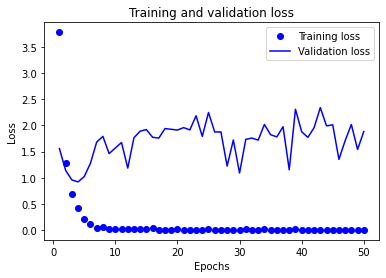

In [ ]:
history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


plt.show()

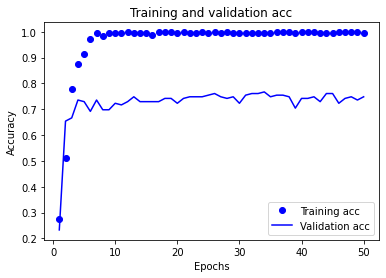

In [ ]:
plt.clf()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
    
epochs = range(1, len(acc) + 1)

blue_dots = 'bo'
solid_blue_line = 'b'
    
plt.plot(epochs, acc, blue_dots, label = 'Training acc')
plt.plot(epochs, val_acc, solid_blue_line, label = 'Validation acc')
plt.title('Training and validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#Model 2

In [ ]:
#landmarks

In [ ]:
print(len(landmarks))

989


In [ ]:
print(landmarks_transformed_input)

[['114.8345' '170.97119' '9.33395' ... '203.845' '211.68393' '57.0849']
 ['101.11293' '173.11176' '-16.12573' ... '185.28841' '226.03188'
  '62.14426']
 ['120.36088' '136.5498' '-3.40521' ... '182.1277' '175.56424'
  '157.72412']
 ...
 ['105.73872' '138.73285' '-126.66352' ... '60.48597' '207.26868'
  '-10.47402']
 ['109.18344' '43.96426' '-57.62205' ... '51.57819' '234.10941'
  '-71.20559']
 ['91.76747' '146.73589' '53.51336' ... '49.35925' '229.09152' '-2.03094']]


In [ ]:
print(landmarks_transformed_input.shape)

(989, 99)


## Model 2

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(landmarks_transformed_input, targets, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
X_train = X_train.astype("float16")
X_val = X_val .astype("float16")
X_test= X_test.astype("float16")

In [ ]:
num_classes = 5
model = Sequential([
  layers.Dense(16,activation='relu',input_shape=(99,)),
  layers.Dense(32, activation='relu'),
  layers.Dense(64, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,activation='softmax')
])
model.compile(optimizer='rmsprop',
loss='categorical_crossentropy',
metrics=['accuracy'])

history= model.fit(X_train, 
                   y_train,
                   epochs=25, batch_size=64, 
                   validation_data=(X_val,y_val))

Epoch 1/25
10/10 [==============================] - 1s 23ms/step - loss: 8.7752 - accuracy: 0.3259 - val_loss: 2.5509 - val_accuracy: 0.3962
Epoch 2/25
10/10 [==============================] - 0s 6ms/step - loss: 2.0423 - accuracy: 0.5253 - val_loss: 1.3798 - val_accuracy: 0.5786
Epoch 3/25
10/10 [==============================] - 0s 8ms/step - loss: 1.5273 - accuracy: 0.5949 - val_loss: 1.5553 - val_accuracy: 0.5912
Epoch 4/25
10/10 [==============================] - 0s 6ms/step - loss: 1.2420 - accuracy: 0.6440 - val_loss: 1.1144 - val_accuracy: 0.6352
Epoch 5/25
10/10 [==============================] - 0s 6ms/step - loss: 0.9693 - accuracy: 0.6994 - val_loss: 1.0229 - val_accuracy: 0.6855
Epoch 6/25
10/10 [==============================] - 0s 6ms/step - loss: 1.0778 - accuracy: 0.7009 - val_loss: 1.5004 - val_accuracy: 0.5849
Epoch 7/25
10/10 [==============================] - 0s 8ms/step - loss: 0.9026 - accuracy: 0.7278 - val_loss: 1.3471 - val_accuracy: 0.5912
Epoch 8/25
10/10 [=

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(images, targets, test_size=0.2, random_state=42)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

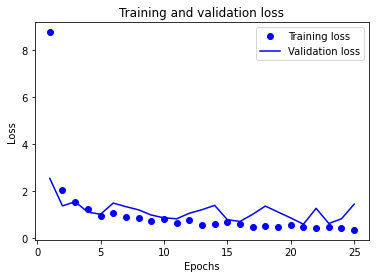

In [ ]:
history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
#plt.ylim((1.58,1.65))

plt.show()

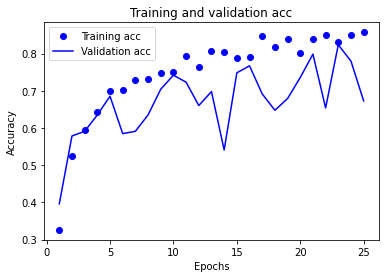

In [ ]:
plt.clf()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
    
epochs = range(1, len(acc) + 1)

blue_dots = 'bo'
solid_blue_line = 'b'
    
plt.plot(epochs, acc, blue_dots, label = 'Training acc')
plt.plot(epochs, val_acc, solid_blue_line, label = 'Validation acc')
plt.title('Training and validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Tuning Model 2
### Model 2.a 
less unit

In [ ]:
num_classes = 5
model = Sequential([
  layers.Dense(8,activation='relu',input_shape=(99,)),
  layers.Dense(16, activation='relu'),
  layers.Dense(32, activation='relu'),
  layers.Dense(64, activation='relu'),
  layers.Dense(num_classes,activation='softmax')
])
model.compile(optimizer='rmsprop',
loss='categorical_crossentropy',
metrics=['accuracy'])

history= model.fit(X_train, 
                   y_train,
                   epochs=25, batch_size=64, 
                   validation_data=(X_val,y_val))

Epoch 1/25
10/10 [==============================] - 1s 24ms/step - loss: 7.2259 - accuracy: 0.3101 - val_loss: 1.9078 - val_accuracy: 0.4025
Epoch 2/25
10/10 [==============================] - 0s 6ms/step - loss: 1.6130 - accuracy: 0.4383 - val_loss: 1.3993 - val_accuracy: 0.4780
Epoch 3/25
10/10 [==============================] - 0s 6ms/step - loss: 1.2869 - accuracy: 0.5206 - val_loss: 1.2738 - val_accuracy: 0.5220
Epoch 4/25
10/10 [==============================] - 0s 6ms/step - loss: 1.1922 - accuracy: 0.5601 - val_loss: 1.2860 - val_accuracy: 0.5157
Epoch 5/25
10/10 [==============================] - 0s 6ms/step - loss: 1.1455 - accuracy: 0.5680 - val_loss: 1.2659 - val_accuracy: 0.4654
Epoch 6/25
10/10 [==============================] - 0s 8ms/step - loss: 1.1270 - accuracy: 0.5570 - val_loss: 1.1887 - val_accuracy: 0.5220
Epoch 7/25
10/10 [==============================] - 0s 8ms/step - loss: 1.0658 - accuracy: 0.5775 - val_loss: 1.0916 - val_accuracy: 0.5597
Epoch 8/25
10/10 [=

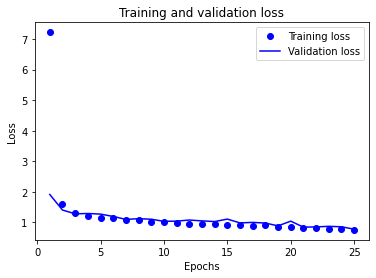

In [ ]:
history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

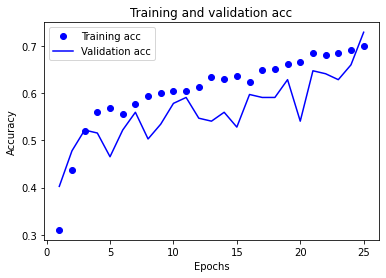

In [ ]:
plt.clf()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
    
epochs = range(1, len(acc) + 1)

blue_dots = 'bo'
solid_blue_line = 'b'
    
plt.plot(epochs, acc, blue_dots, label = 'Training acc')
plt.plot(epochs, val_acc, solid_blue_line, label = 'Validation acc')
plt.title('Training and validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Model 2.b
add layer

In [ ]:
num_classes = 5
model = Sequential([
  layers.Dense(8,activation='relu',input_shape=(99,)),
  layers.Dense(16, activation='relu'),
  layers.Dense(32, activation='relu'),
  layers.Dense(64, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,activation='softmax')
])
model.compile(optimizer='rmsprop',
loss='categorical_crossentropy',
metrics=['accuracy'])

history= model.fit(X_train, 
                   y_train,
                   epochs=25, batch_size=64, 
                   validation_data=(X_val,y_val))

Epoch 1/25
10/10 [==============================] - 1s 24ms/step - loss: 2.5604 - accuracy: 0.3070 - val_loss: 1.2705 - val_accuracy: 0.4465
Epoch 2/25
10/10 [==============================] - 0s 7ms/step - loss: 1.3158 - accuracy: 0.4858 - val_loss: 1.1498 - val_accuracy: 0.5283
Epoch 3/25
10/10 [==============================] - 0s 7ms/step - loss: 1.2295 - accuracy: 0.5206 - val_loss: 1.0712 - val_accuracy: 0.5597
Epoch 4/25
10/10 [==============================] - 0s 7ms/step - loss: 1.0679 - accuracy: 0.5886 - val_loss: 1.1482 - val_accuracy: 0.5786
Epoch 5/25
10/10 [==============================] - 0s 6ms/step - loss: 1.1291 - accuracy: 0.5744 - val_loss: 1.0519 - val_accuracy: 0.5849
Epoch 6/25
10/10 [==============================] - 0s 9ms/step - loss: 0.9959 - accuracy: 0.5981 - val_loss: 1.0664 - val_accuracy: 0.5346
Epoch 7/25
10/10 [==============================] - 0s 7ms/step - loss: 0.9973 - accuracy: 0.6076 - val_loss: 1.0015 - val_accuracy: 0.5975
Epoch 8/25
10/10 [=

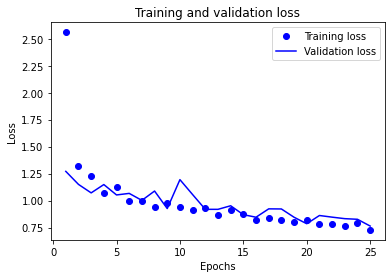

In [ ]:
history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

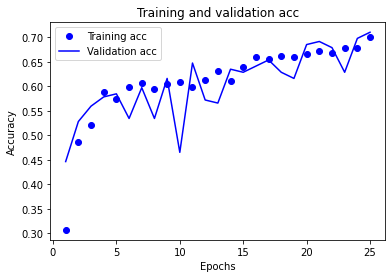

In [ ]:
plt.clf()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
    
epochs = range(1, len(acc) + 1)

blue_dots = 'bo'
solid_blue_line = 'b'
    
plt.plot(epochs, acc, blue_dots, label = 'Training acc')
plt.plot(epochs, val_acc, solid_blue_line, label = 'Validation acc')
plt.title('Training and validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Model 2.c
less layer


In [ ]:
num_classes = 5
model = Sequential([
  layers.Dense(8,activation='relu',input_shape=(99,)),
  layers.Dense(16, activation='relu'),
  layers.Dense(num_classes,activation='softmax')
])
model.compile(optimizer='rmsprop',
loss='categorical_crossentropy',
metrics=['accuracy'])

history= model.fit(X_train, 
                   y_train,
                   epochs=25, batch_size=64, 
                   validation_data=(X_val,y_val))

Epoch 1/25
10/10 [==============================] - 1s 20ms/step - loss: 55.5573 - accuracy: 0.2073 - val_loss: 26.7637 - val_accuracy: 0.2138
Epoch 2/25
10/10 [==============================] - 0s 6ms/step - loss: 20.4810 - accuracy: 0.2247 - val_loss: 13.9047 - val_accuracy: 0.2075
Epoch 3/25
10/10 [==============================] - 0s 7ms/step - loss: 9.9800 - accuracy: 0.2532 - val_loss: 6.5494 - val_accuracy: 0.2327
Epoch 4/25
10/10 [==============================] - 0s 8ms/step - loss: 4.3783 - accuracy: 0.2911 - val_loss: 3.2255 - val_accuracy: 0.3145
Epoch 5/25
10/10 [==============================] - 0s 6ms/step - loss: 2.7793 - accuracy: 0.2864 - val_loss: 2.4809 - val_accuracy: 0.2830
Epoch 6/25
10/10 [==============================] - 0s 6ms/step - loss: 2.1816 - accuracy: 0.2611 - val_loss: 2.0616 - val_accuracy: 0.2579
Epoch 7/25
10/10 [==============================] - 0s 6ms/step - loss: 1.9262 - accuracy: 0.2753 - val_loss: 1.9361 - val_accuracy: 0.2201
Epoch 8/25
10/1

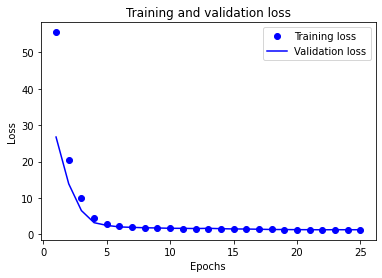

In [ ]:
history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

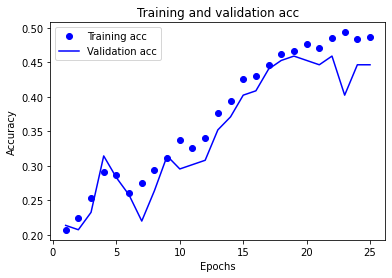

In [ ]:
plt.clf()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
    
epochs = range(1, len(acc) + 1)

blue_dots = 'bo'
solid_blue_line = 'b'
    
plt.plot(epochs, acc, blue_dots, label = 'Training acc')
plt.plot(epochs, val_acc, solid_blue_line, label = 'Validation acc')
plt.title('Training and validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Model 2.d
Drop out

In [ ]:
num_classes = 5
model = Sequential([
  layers.Dense(8,activation='relu',input_shape=(99,)),
  layers.Dense(16, activation='relu'),
  layers.Dense(32, activation='relu'),
  layers.Dense(64, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(256, activation='relu'),
  layers.Dropout(0.3),
  layers.Dense(num_classes,activation='softmax')
])
model.compile(optimizer='rmsprop',
loss='categorical_crossentropy',
metrics=['accuracy'])

history= model.fit(X_train, 
                   y_train,
                   epochs=25, batch_size=64, 
                   validation_data=(X_val,y_val))

Epoch 1/25
10/10 [==============================] - 1s 59ms/step - loss: 2.7845 - accuracy: 0.2690 - val_loss: 1.6342 - val_accuracy: 0.3899
Epoch 2/25
10/10 [==============================] - 0s 8ms/step - loss: 1.5718 - accuracy: 0.3655 - val_loss: 1.3295 - val_accuracy: 0.4465
Epoch 3/25
10/10 [==============================] - 0s 8ms/step - loss: 1.3781 - accuracy: 0.4177 - val_loss: 1.2692 - val_accuracy: 0.4906
Epoch 4/25
10/10 [==============================] - 0s 7ms/step - loss: 1.3578 - accuracy: 0.4130 - val_loss: 1.3252 - val_accuracy: 0.4340
Epoch 5/25
10/10 [==============================] - 0s 7ms/step - loss: 1.2758 - accuracy: 0.4684 - val_loss: 1.2510 - val_accuracy: 0.5283
Epoch 6/25
10/10 [==============================] - 0s 7ms/step - loss: 1.1972 - accuracy: 0.5047 - val_loss: 1.1976 - val_accuracy: 0.5031
Epoch 7/25
10/10 [==============================] - 0s 7ms/step - loss: 1.1855 - accuracy: 0.5285 - val_loss: 1.1793 - val_accuracy: 0.5157
Epoch 8/25
10/10 [=

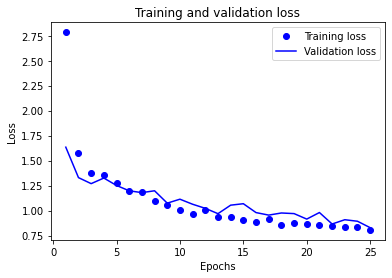

In [ ]:
history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

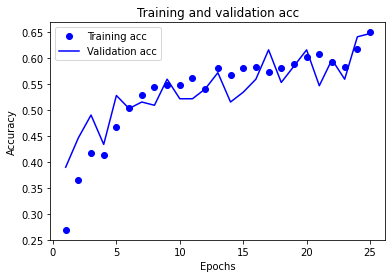

In [ ]:
plt.clf()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
    
epochs = range(1, len(acc) + 1)

blue_dots = 'bo'
solid_blue_line = 'b'
    
plt.plot(epochs, acc, blue_dots, label = 'Training acc')
plt.plot(epochs, val_acc, solid_blue_line, label = 'Validation acc')
plt.title('Training and validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()